# Importing data

In [2]:
import pandas as pd

In [3]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")
#print(routes_df.keys())
#print(airports_df.keys())

In [4]:
airports_by_iata_df = airports_df.groupby("IATA")

In [5]:
airports_by_longtitude_df = airports_df.groupby("Longitude")
airports_by_lattitude_df = airports_df.groupby("Latitude")

# Creating a directed multigraph

In [6]:
import networkx as nx

In [7]:
airport_nodes = list(airports_by_iata_df.groups)

In [8]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

In [9]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)

edges = [(airport_src[i],airport_dest[i]) for i in range(len(airport_src))
        if airport_src[i] in airport_nodes and airport_dest[i] in airport_nodes
        ]

'''
for edge in edges:
    if edge[0] not in airport_nodes or edge[1] not in airport_nodes:
        edges.remove(edge)
        print(edge in edges)
'''

airport_routes_digraph.add_edges_from(edges);


# Plotting the graph

In [10]:
import matplotlib.pyplot as plt

In [11]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        #print(IATA)
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0


In [12]:
positions = {}

for node in airport_routes_digraph.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    


In [13]:
options = {
    'width': 0.2,
    'alpha': 0.9,
    'node_size': 50,
    'with_labels': False
}

In [14]:
'''fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))

fig.savefig("airportgraph.png")'''

'fig = plt.figure(figsize=(26,15))\nnx.draw_networkx(airport_routes_digraph, positions, \n                 width=0.1,alpha=0.5,node_size=2,with_labels=False, \n                 ax=fig.add_subplot(111))\n\nfig.savefig("airportgraph.png")'

In [15]:
len(airport_routes_digraph.nodes)

5653

In [16]:
len(airport_routes_digraph.edges)

66067

'\narr[0].scatter(degrees, count, s=10, color=\'b\')\narr[1].scatter(degrees, count, s=10, color=\'b\')\nplt.xscale(\'log\')\nplt.yscale(\'log\')\nplt.ylabel("Count")\nplt.xlabel("Degree")\n'

<Figure size 1872x1080 with 0 Axes>

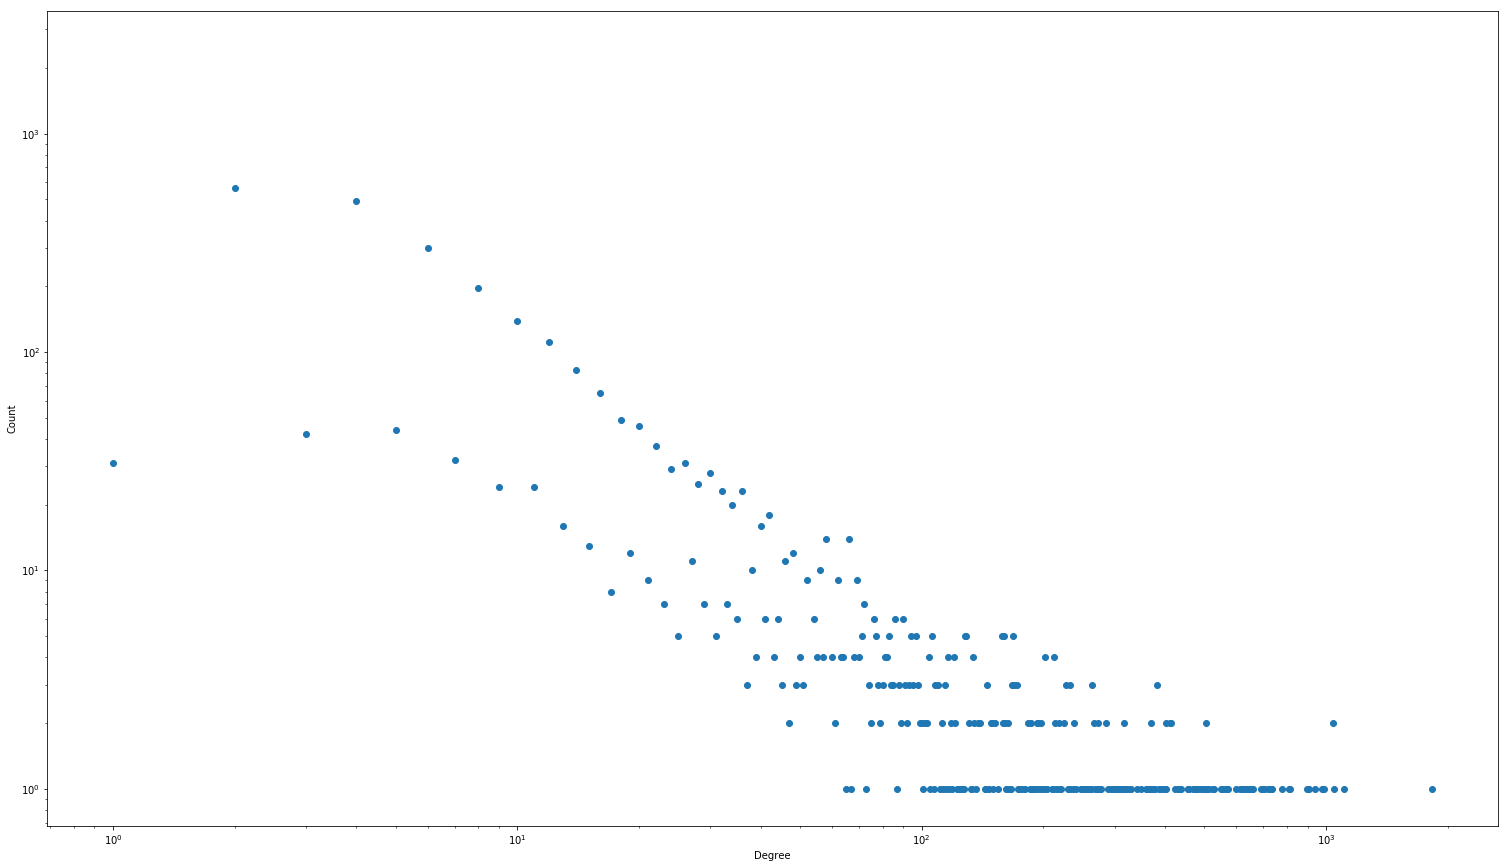

In [17]:
import collections

degreeforeach = sorted([d for n,d in airport_routes_digraph.degree], reverse=True)
degreeCount = collections.Counter(degreeforeach)
degrees, count = zip(*degreeCount.items())
fig = plt.figure(figsize=(26,15))
plt.scatter(degrees, count, s=10, color='b')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('regularplot.png')

plt.clf()
fig = plt.figure(figsize=(26,15))
plt.loglog(degrees, count,'o')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('powerlawplot.png')




#a, arr = plt.subplots(2, sharex=True)

'''
arr[0].scatter(degrees, count, s=10, color='b')
arr[1].scatter(degrees, count, s=10, color='b')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Degree")
'''

# Community Detection

In [18]:
import community

In [38]:
community_partition = community.best_partition(airport_routes_digraph.to_undirected(),resolution=1.0)

0
2494


In [50]:
values = [community_partition.get(node) for node in airport_routes_digraph.nodes()]

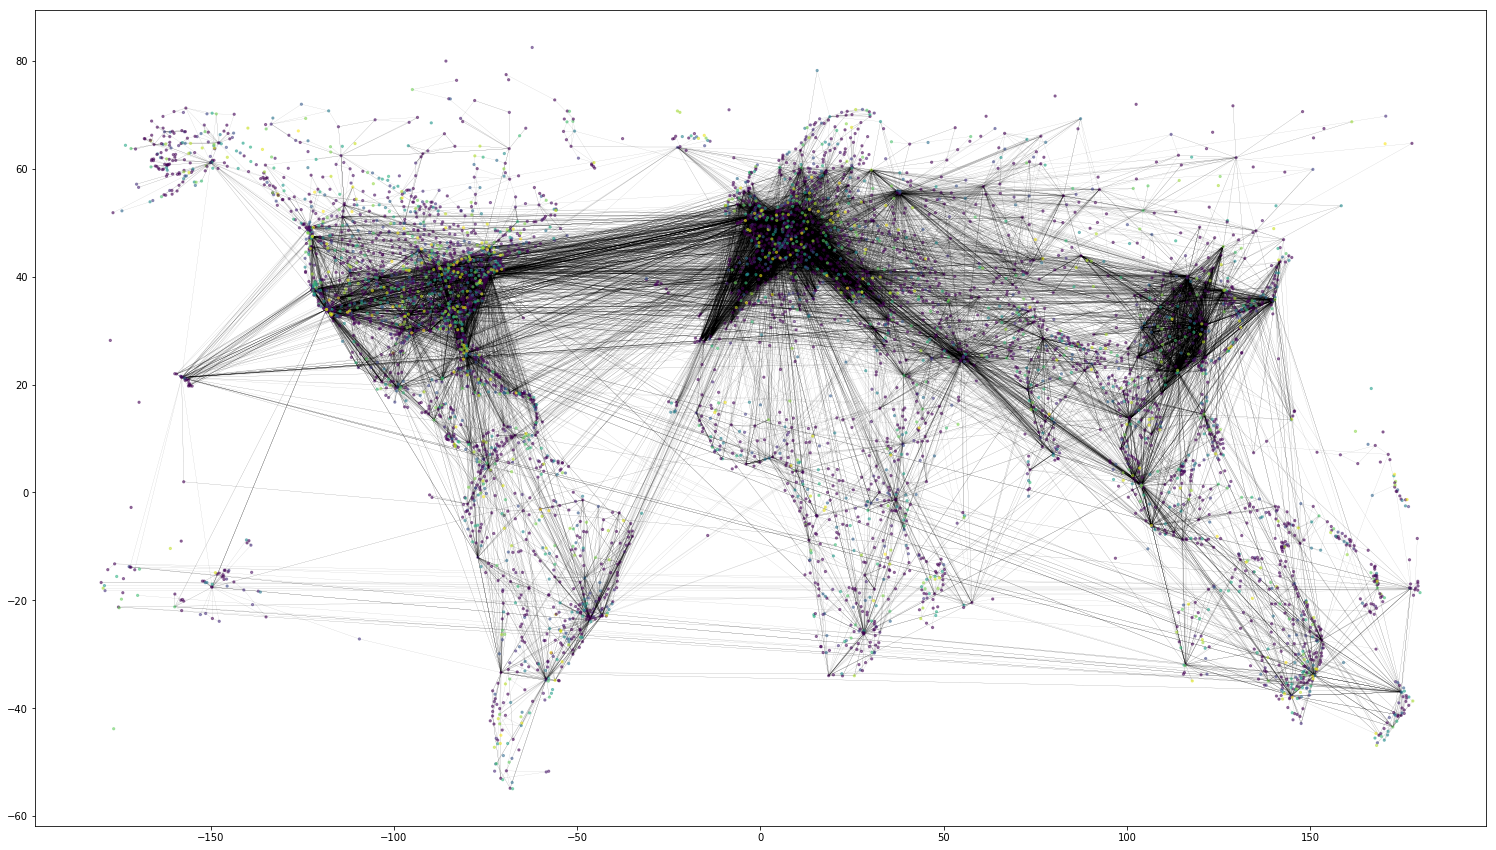

In [51]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph.to_undirected(), positions, 
                 width=0.1,alpha=0.5,node_size=5,with_labels=False, 
                 node_color = values, ax=fig.add_subplot(111))

fig.savefig("airportgraph_communities.png")

These communities do not make much sense, so we try checking the modularity metric for communities defines by continent.

## Communities by Continent

**Preparing the data**

In [182]:
countriescontinents_df = pd.read_csv("data/CountriesContinents.csv")

In [183]:
countriescontinents_df.set_index(['Country','Continent']);

In [184]:
airports_continents = airports_df.merge(countriescontinents_df,on="Country",how="inner")

In [185]:
airports_continents_by_continent = airports_continents.groupby("Continent")
continents = list(airports_continents_by_continent.groups)


In [186]:
eur_df = list(airports_continents.loc[airports_continents['Continent'] == 'Europe'].groupby('IATA').groups);
oce_df = list(airports_continents.loc[airports_continents['Continent'] == 'Oceania'].groupby('IATA').groups);
afr_df = list(airports_continents.loc[airports_continents['Continent'] == 'Africa'].groupby('IATA').groups);
asia_df = list(airports_continents.loc[airports_continents['Continent'] == 'Asia'].groupby('IATA').groups);
na_df = list(airports_continents.loc[airports_continents['Continent'] == 'North America'].groupby('IATA').groups);
sa_df = list(airports_continents.loc[airports_continents['Continent'] == 'South America'].groupby('IATA').groups);

In [187]:
def calculateLC(graph,community_df):
    lc = 0
    #community_df = list(community_df.groupby('WikiPageName').groups)
    for node in list(graph.nodes()):
        if node in community_df:
            lc += len([i for i in graph.neighbors(node) if i in community_df])
        
    return lc/2.0

def calculateKC(graph,community_df):
    return sum([graph.degree(node) for node in community_df])
    
def Mc(G,commmunity_df):
    return (calculateLC(G,commmunity_df)/len(G.edges()))-(calculateKC(G,commmunity_df)/(2*len(G.edges())))**2


In [188]:
#['Europe', 'Oceania', 'Africa', 'Asia', 'North America', 'South America']

modularity = Mc(airport_routes_digraph,eur_df) + Mc(airport_routes_digraph,oce_df) + Mc(airport_routes_digraph,afr_df) + Mc(airport_routes_digraph,asia_df) + Mc(airport_routes_digraph,na_df) + Mc(airport_routes_digraph,sa_df)

In [189]:
modularity #is bad, as expected.
'''A partition with a sub-optimal but positive
modularity, M=0.22, fails to correctly
identify the communities present in the
network.
'''

0.23692615072577836

In [211]:
nodeColors = []
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    
    if continent == 'Asia':
        nodeColors.append('red')
    elif continent == 'Europe':
        nodeColors.append('blue')
    elif continent == 'Oceania':
        nodeColors.append('cyan')
    elif continent == 'Africa':
        nodeColors.append('pink')
    elif continent == 'North America':
        nodeColors.append('green')
    elif continent == 'South America':
        nodeColors.append('yellow')    
    else:
        nodeColors.append('brown')

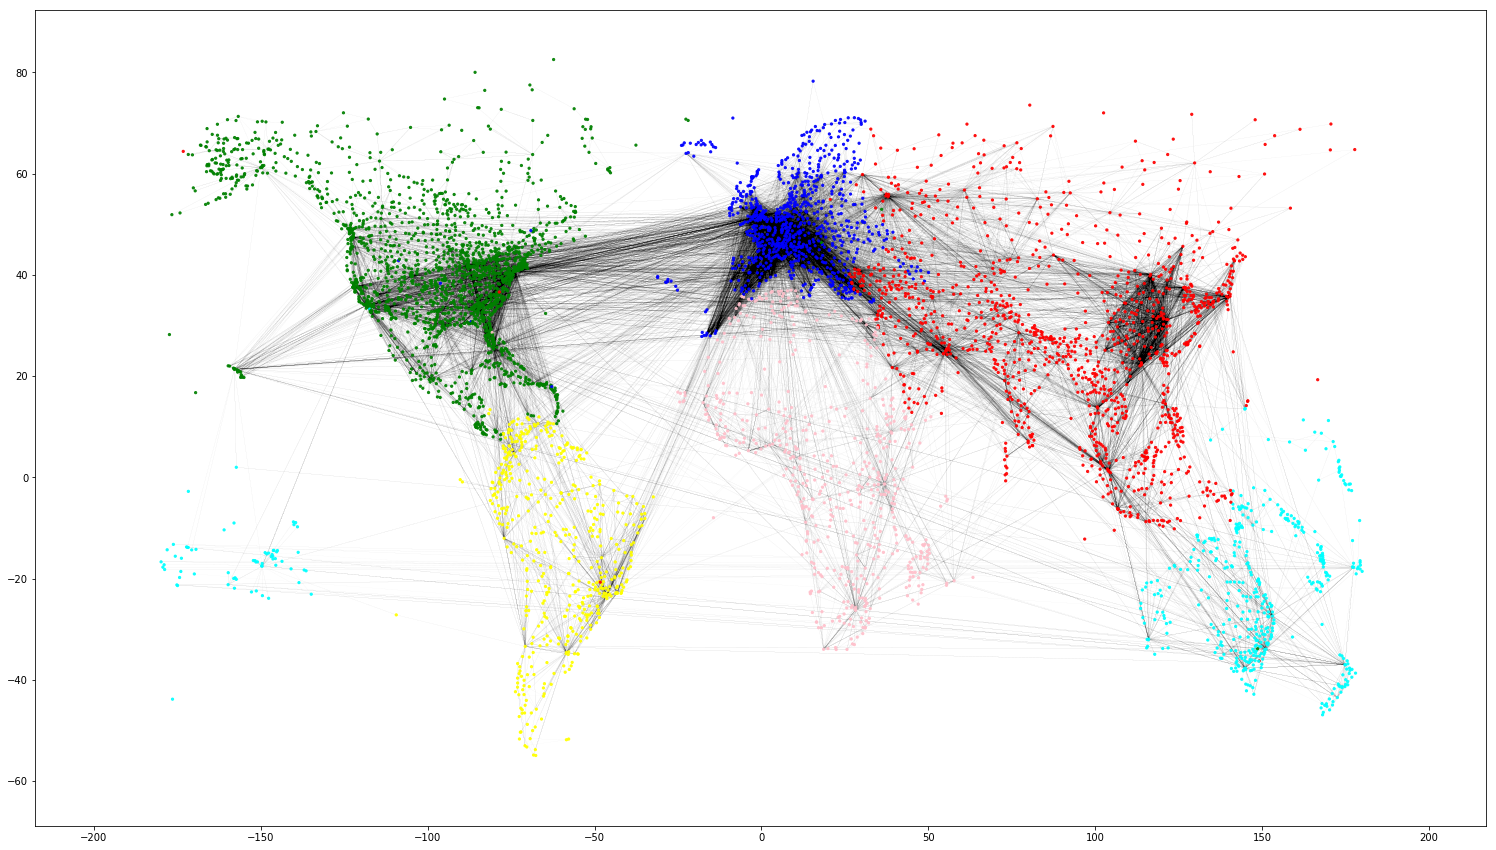

In [213]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = nodeColors, ax=fig.add_subplot(111),arrowstyle='-')

fig.savefig("airportgraph_continent_communities.png")